--------------------------------------------------------------------------------

In [1]:
!pip install tensorflow

In [4]:
# System & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from IPython.display import display, clear_output

# ML & DL
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# UI
import ipywidgets as widgets
import os
import datetime


In [6]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os

# Reproducibility
random.seed(42)
np.random.seed(42)

# Users & Hosts
users = [f"user{i:02d}" for i in range(1, 31)]
pcs = [f"workstation{i}" for i in range(1, 11)] + [f"fileserver{i}" for i in range(1, 4)] + ["domain_controller1"]

# logon.csv
logon_records = []
for user in users:
    for _ in range(random.randint(20, 50)):
        pc = random.choice(pcs)
        log_date = datetime(2020, 1, 1) + timedelta(days=random.randint(0, 90))
        log_time = datetime.strptime(f"{random.randint(0,23)}:{random.randint(0,59)}", "%H:%M").time()
        logon_records.append([user, pc, log_date.date().isoformat(), log_time.strftime("%H:%M")])
logon_df = pd.DataFrame(logon_records, columns=["user", "pc", "date", "time"])

# device.csv
device_records = []
for user in users:
    for _ in range(random.randint(5, 15)):
        pc = random.choice(pcs)
        date = datetime(2020, 1, 1) + timedelta(days=random.randint(0, 90))
        time = datetime.strptime(f"{random.randint(0,23)}:{random.randint(0,59)}", "%H:%M").time()
        device_records.append([user, pc, date.date().isoformat(), time.strftime("%H:%M"), "usb_insert"])
device_df = pd.DataFrame(device_records, columns=["user", "pc", "date", "time", "activity"])

# file.csv
file_types = ["docx", "pdf", "xls", "ppt"]
file_records = []
for user in users:
    for _ in range(random.randint(10, 30)):
        pc = random.choice(pcs)
        date = datetime(2020, 1, 1) + timedelta(days=random.randint(0, 90))
        time = datetime.strptime(f"{random.randint(0,23)}:{random.randint(0,59)}", "%H:%M").time()
        filename = f"file_{random.randint(1000,9999)}.{random.choice(file_types)}"
        file_records.append([user, pc, date.date().isoformat(), time.strftime("%H:%M"), filename])
file_df = pd.DataFrame(file_records, columns=["user", "pc", "date", "time", "filename"])

# users.csv
departments = ["Engineering", "Finance", "HR", "Research"]
roles = ["Analyst", "Manager", "Engineer", "Admin"]
users_df = pd.DataFrame({
    "user": users,
    "dept": np.random.choice(departments, size=len(users)),
    "role": np.random.choice(roles, size=len(users))
})

# psychometric.csv
traits = ["O", "C", "E", "A", "N"]
psychometric_df = pd.DataFrame({
    "user": users,
    **{trait: np.random.normal(50, 10, len(users)).round(2) for trait in traits}
})

# Save them
os.makedirs("/mnt/data/sim_cert/", exist_ok=True)
logon_df.to_csv("/mnt/data/sim_cert/logon.csv", index=False)
device_df.to_csv("/mnt/data/sim_cert/device.csv", index=False)
file_df.to_csv("/mnt/data/sim_cert/file.csv", index=False)
users_df.to_csv("/mnt/data/sim_cert/users.csv", index=False)
psychometric_df.to_csv("/mnt/data/sim_cert/psychometric.csv", index=False)

print("✅ Synthetic CERT-style dataset created successfully!")


✅ Synthetic CERT-style dataset created successfully!


# Load Synthetic Dataset

In [7]:
# Load the simulated CERT-style dataset
DATA_PATH = "/mnt/data/sim_cert/"

logon_df = pd.read_csv(DATA_PATH + "logon.csv")
device_df = pd.read_csv(DATA_PATH + "device.csv")
file_df = pd.read_csv(DATA_PATH + "file.csv")
users_df = pd.read_csv(DATA_PATH + "users.csv")
psych_df = pd.read_csv(DATA_PATH + "psychometric.csv")


# Preprocess Users & Filter

In [8]:
# Merge user profiles and psychometrics
users_df = users_df.drop_duplicates('user')
merged_df = pd.merge(users_df, psych_df, on='user', how='left')

# Choose 30 users
selected_users = merged_df['user'].unique()[:30]
logon_df = logon_df[logon_df['user'].isin(selected_users)]
file_df = file_df[file_df['user'].isin(selected_users)]
device_df = device_df[device_df['user'].isin(selected_users)]


# Build Network Graph of User-Host Interactions

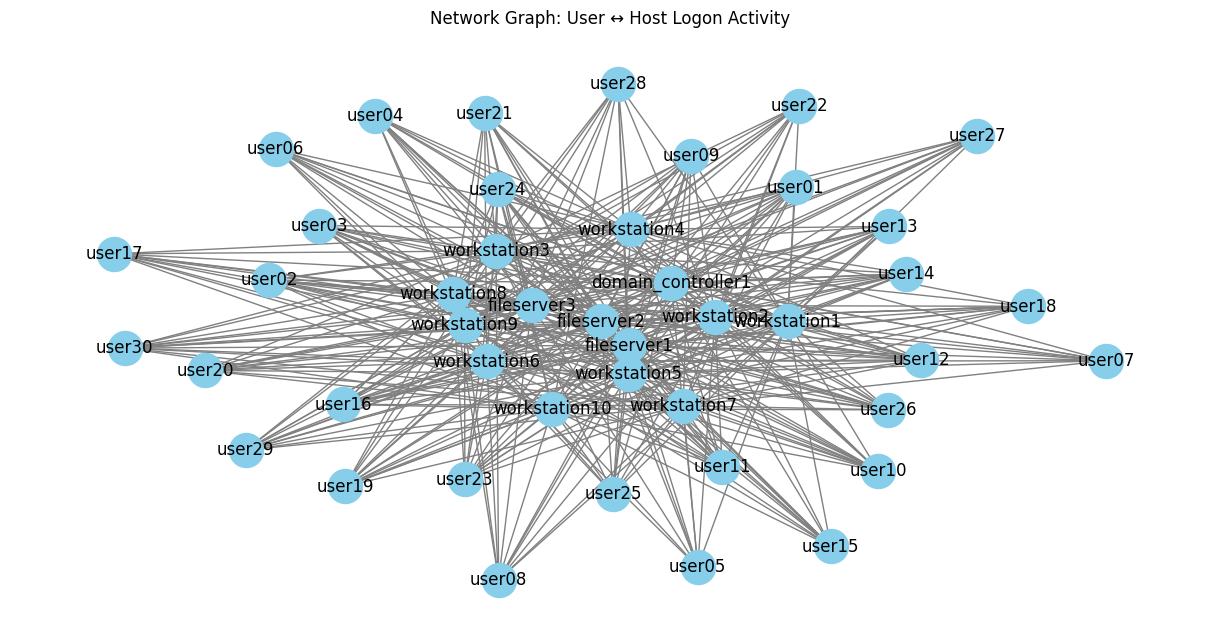

In [9]:
# Create a bipartite graph
G = nx.Graph()
hosts = list(set(logon_df['pc'].unique()).union(set(file_df['pc'].unique())))
G.add_nodes_from(selected_users, bipartite=0, type='user')
G.add_nodes_from(hosts, bipartite=1, type='host')

# Add edges based on logon frequency
logon_edges = logon_df.groupby(['user', 'pc']).size().reset_index(name='weight')
for _, row in logon_edges.iterrows():
    G.add_edge(row['user'], row['pc'], weight=row['weight'])

# Visualize
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=600, node_color='skyblue', edge_color='gray')
plt.title("Network Graph: User ↔ Host Logon Activity")
plt.show()


# Prepare LSTM Input Sequences

In [10]:
# Create datetime and encode hosts
logon_df['datetime'] = pd.to_datetime(logon_df['date'] + ' ' + logon_df['time'])
logon_df = logon_df.sort_values(['user', 'datetime'])

host_encoder = LabelEncoder()
logon_df['pc_encoded'] = host_encoder.fit_transform(logon_df['pc'])

# Build sequences
sequence_data, sequence_labels = [], []
seq_len = 10

for user in selected_users:
    user_logs = logon_df[logon_df['user'] == user]
    encoded_seq = user_logs['pc_encoded'].values
    for i in range(len(encoded_seq) - seq_len):
        sequence_data.append(encoded_seq[i:i+seq_len])
        sequence_labels.append(encoded_seq[i+seq_len])

# Pad and normalize
X = pad_sequences(sequence_data, padding='post')
y = np.array(sequence_labels)

X = MinMaxScaler().fit_transform(X)
X = X.reshape((X.shape[0], seq_len, 1))

# Split into train/test
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


# Define and Train the LSTM Model

In [11]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 56.8903 - val_loss: 53.2786
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 46.0732 - val_loss: 18.6036
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 18.3423 - val_loss: 16.9666
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 17.3920 - val_loss: 17.0895
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 17.3886 - val_loss: 16.6664


# Real-Time Streaming Simulation

In [12]:
user_sequences = {u: [] for u in selected_users}
anomaly_scores = {}

for idx, row in logon_df.iterrows():
    user = row['user']
    pc = row['pc']
    pc_encoded = host_encoder.transform([pc])[0]
    user_sequences[user].append(pc_encoded)

    if len(user_sequences[user]) > seq_len:
        user_sequences[user] = user_sequences[user][-seq_len:]

    if len(user_sequences[user]) == seq_len:
        seq = np.array(user_sequences[user]).reshape(1, seq_len)
        norm_seq = MinMaxScaler().fit_transform(seq)
        input_seq = norm_seq.reshape((1, seq_len, 1))
        pred = model.predict(input_seq, verbose=0)
        error = abs(pred[0][0] - pc_encoded)
        if error > 5:
            anomaly_scores.setdefault(user, []).append((row['datetime'], error))


# Interactive Anomaly Dashboard

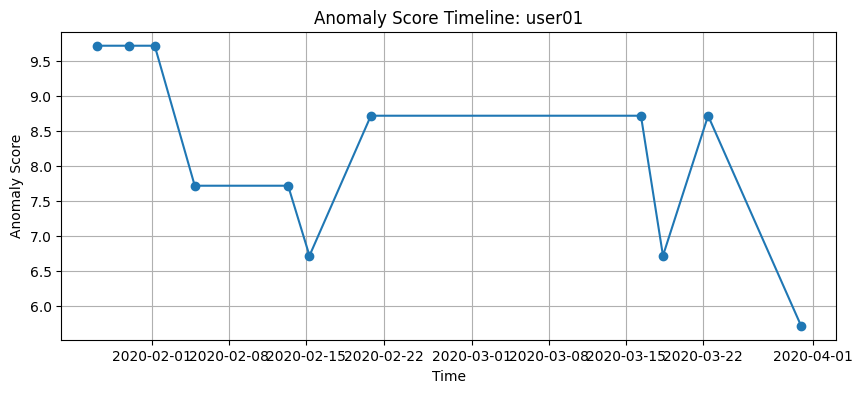

In [13]:
def display_anomalies(user_filter=None):
    clear_output()
    if user_filter:
        scores = anomaly_scores.get(user_filter, [])
        if not scores:
            print(f"No anomalies detected for {user_filter}.")
            return
        times = [t[0] for t in scores]
        errors = [t[1] for t in scores]
        plt.figure(figsize=(10, 4))
        plt.plot(times, errors, marker='o')
        plt.title(f"Anomaly Score Timeline: {user_filter}")
        plt.xlabel("Time")
        plt.ylabel("Anomaly Score")
        plt.grid()
        plt.show()
    else:
        top_users = sorted(anomaly_scores.items(), key=lambda x: -np.mean([e[1] for e in x[1]]))[:5]
        for user, logs in top_users:
            print(f"User: {user}, Avg Anomaly Score: {np.mean([e[1] for e in logs]):.2f}")

# Widgets
user_dropdown = widgets.Dropdown(options=list(selected_users), description="User")
button = widgets.Button(description="🔁 Rerun with Live Simulation")

def on_button_click(b):
    display_anomalies(user_dropdown.value)

button.on_click(on_button_click)
display(user_dropdown, button)
